# Project Name: Collaborative Filtering for Recommendation Systems: User-Based and Item-Based Approaches

**Overview:**
This project introduces students to the core principles of collaborative filtering, a foundational technique in building recommender systems. Students will implement both user-based and item-based collaborative filtering to generate personalized recommendations based on patterns of user behavior and item similarities.

**You have:**
* A user-item interaction dataset (e.g., ratings or purchase history) with identifiable users and items.
* Basic knowledge of Python, pandas, NumPy, and similarity metrics such as cosine similarity or Pearson correlation.

**We will:**
1. Implement user-based collaborative filtering by computing user-user similarities and recommending items liked by similar users.
2. Implement item-based collaborative filtering by analyzing item-item similarities based on user interaction history.
3. Generate top-N personalized recommendations using both methods and evaluate their performance using metrics like precision, recall, and coverage.

**Goal:**
Students will gain hands-on experience in developing collaborative filtering algorithms, understanding how user preferences and item relationships can be leveraged to build effective recommender systems for personalized content delivery.

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import re
import seaborn as sns
import base64
from IPython.display import display, HTML
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [12]:
image_paths = [f"recsys{i}.png" for i in range(1,11)]
image_size = [700]*11
images_html = []

mime_map = {
    ".png": "image/png",
    ".jpg": "image/jpeg",
    ".jpeg": "image/jpeg",
    ".gif": "image/gif",
    ".webp": "image/webp"
}

for i, path in enumerate(image_paths):
    ext = os.path.splitext(path)[1].lower()
    mime = mime_map.get(ext, "image/png")

    with open("./img/"+path, "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")

    img_tag = f'<img src="data:{mime};base64,{encoded}" style="display: block; margin-left: auto; margin-right: auto; width: {image_size[i]}px;" /><br>'
    images_html.append(img_tag)


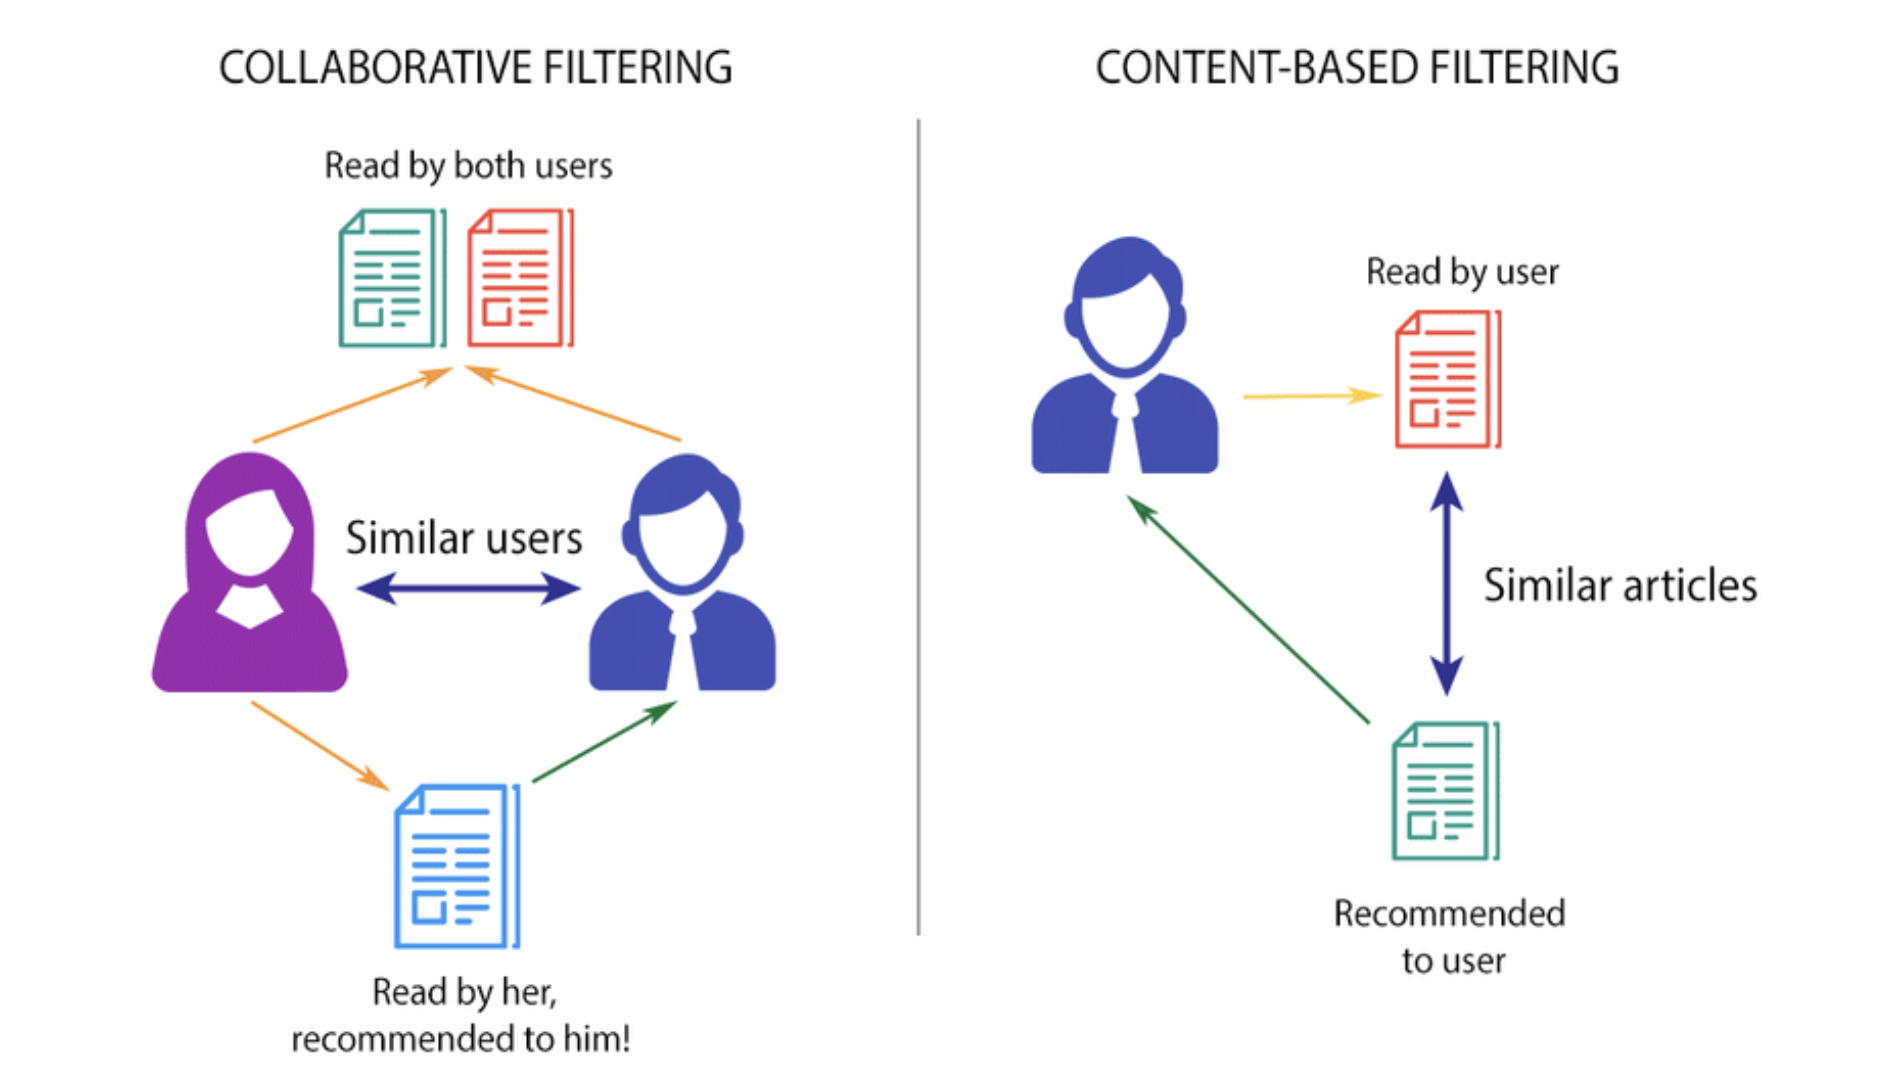

In [3]:
display(HTML(images_html[0]))


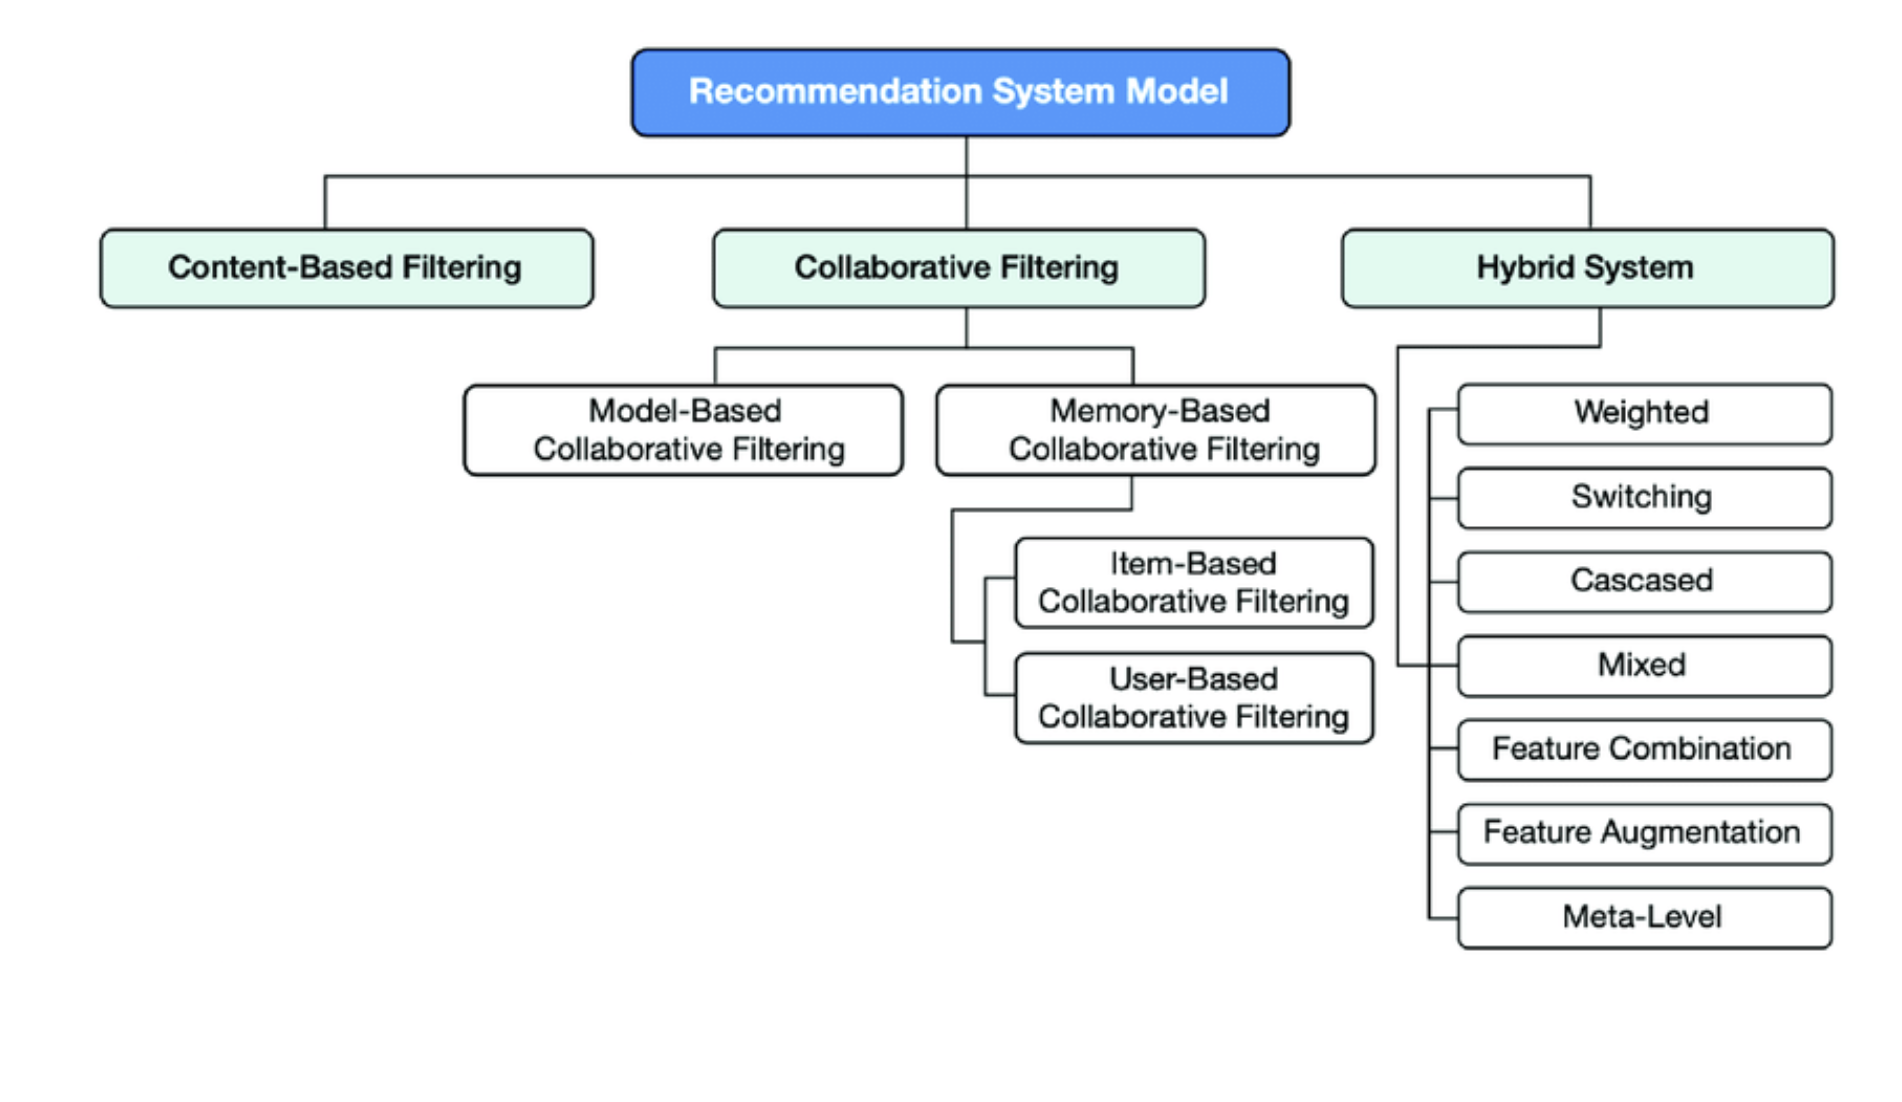

In [4]:
display(HTML(images_html[1]))


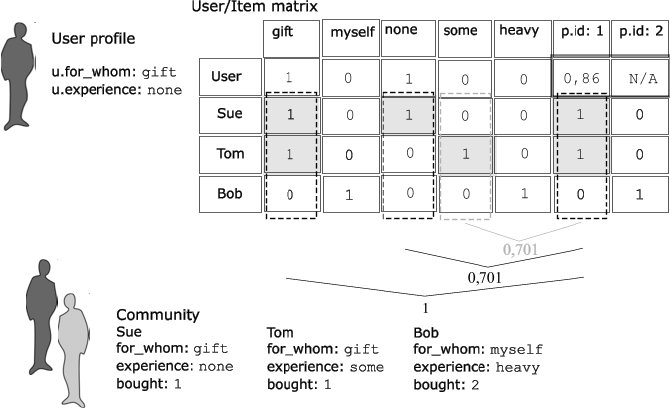

In [13]:
display(HTML(images_html[7]))


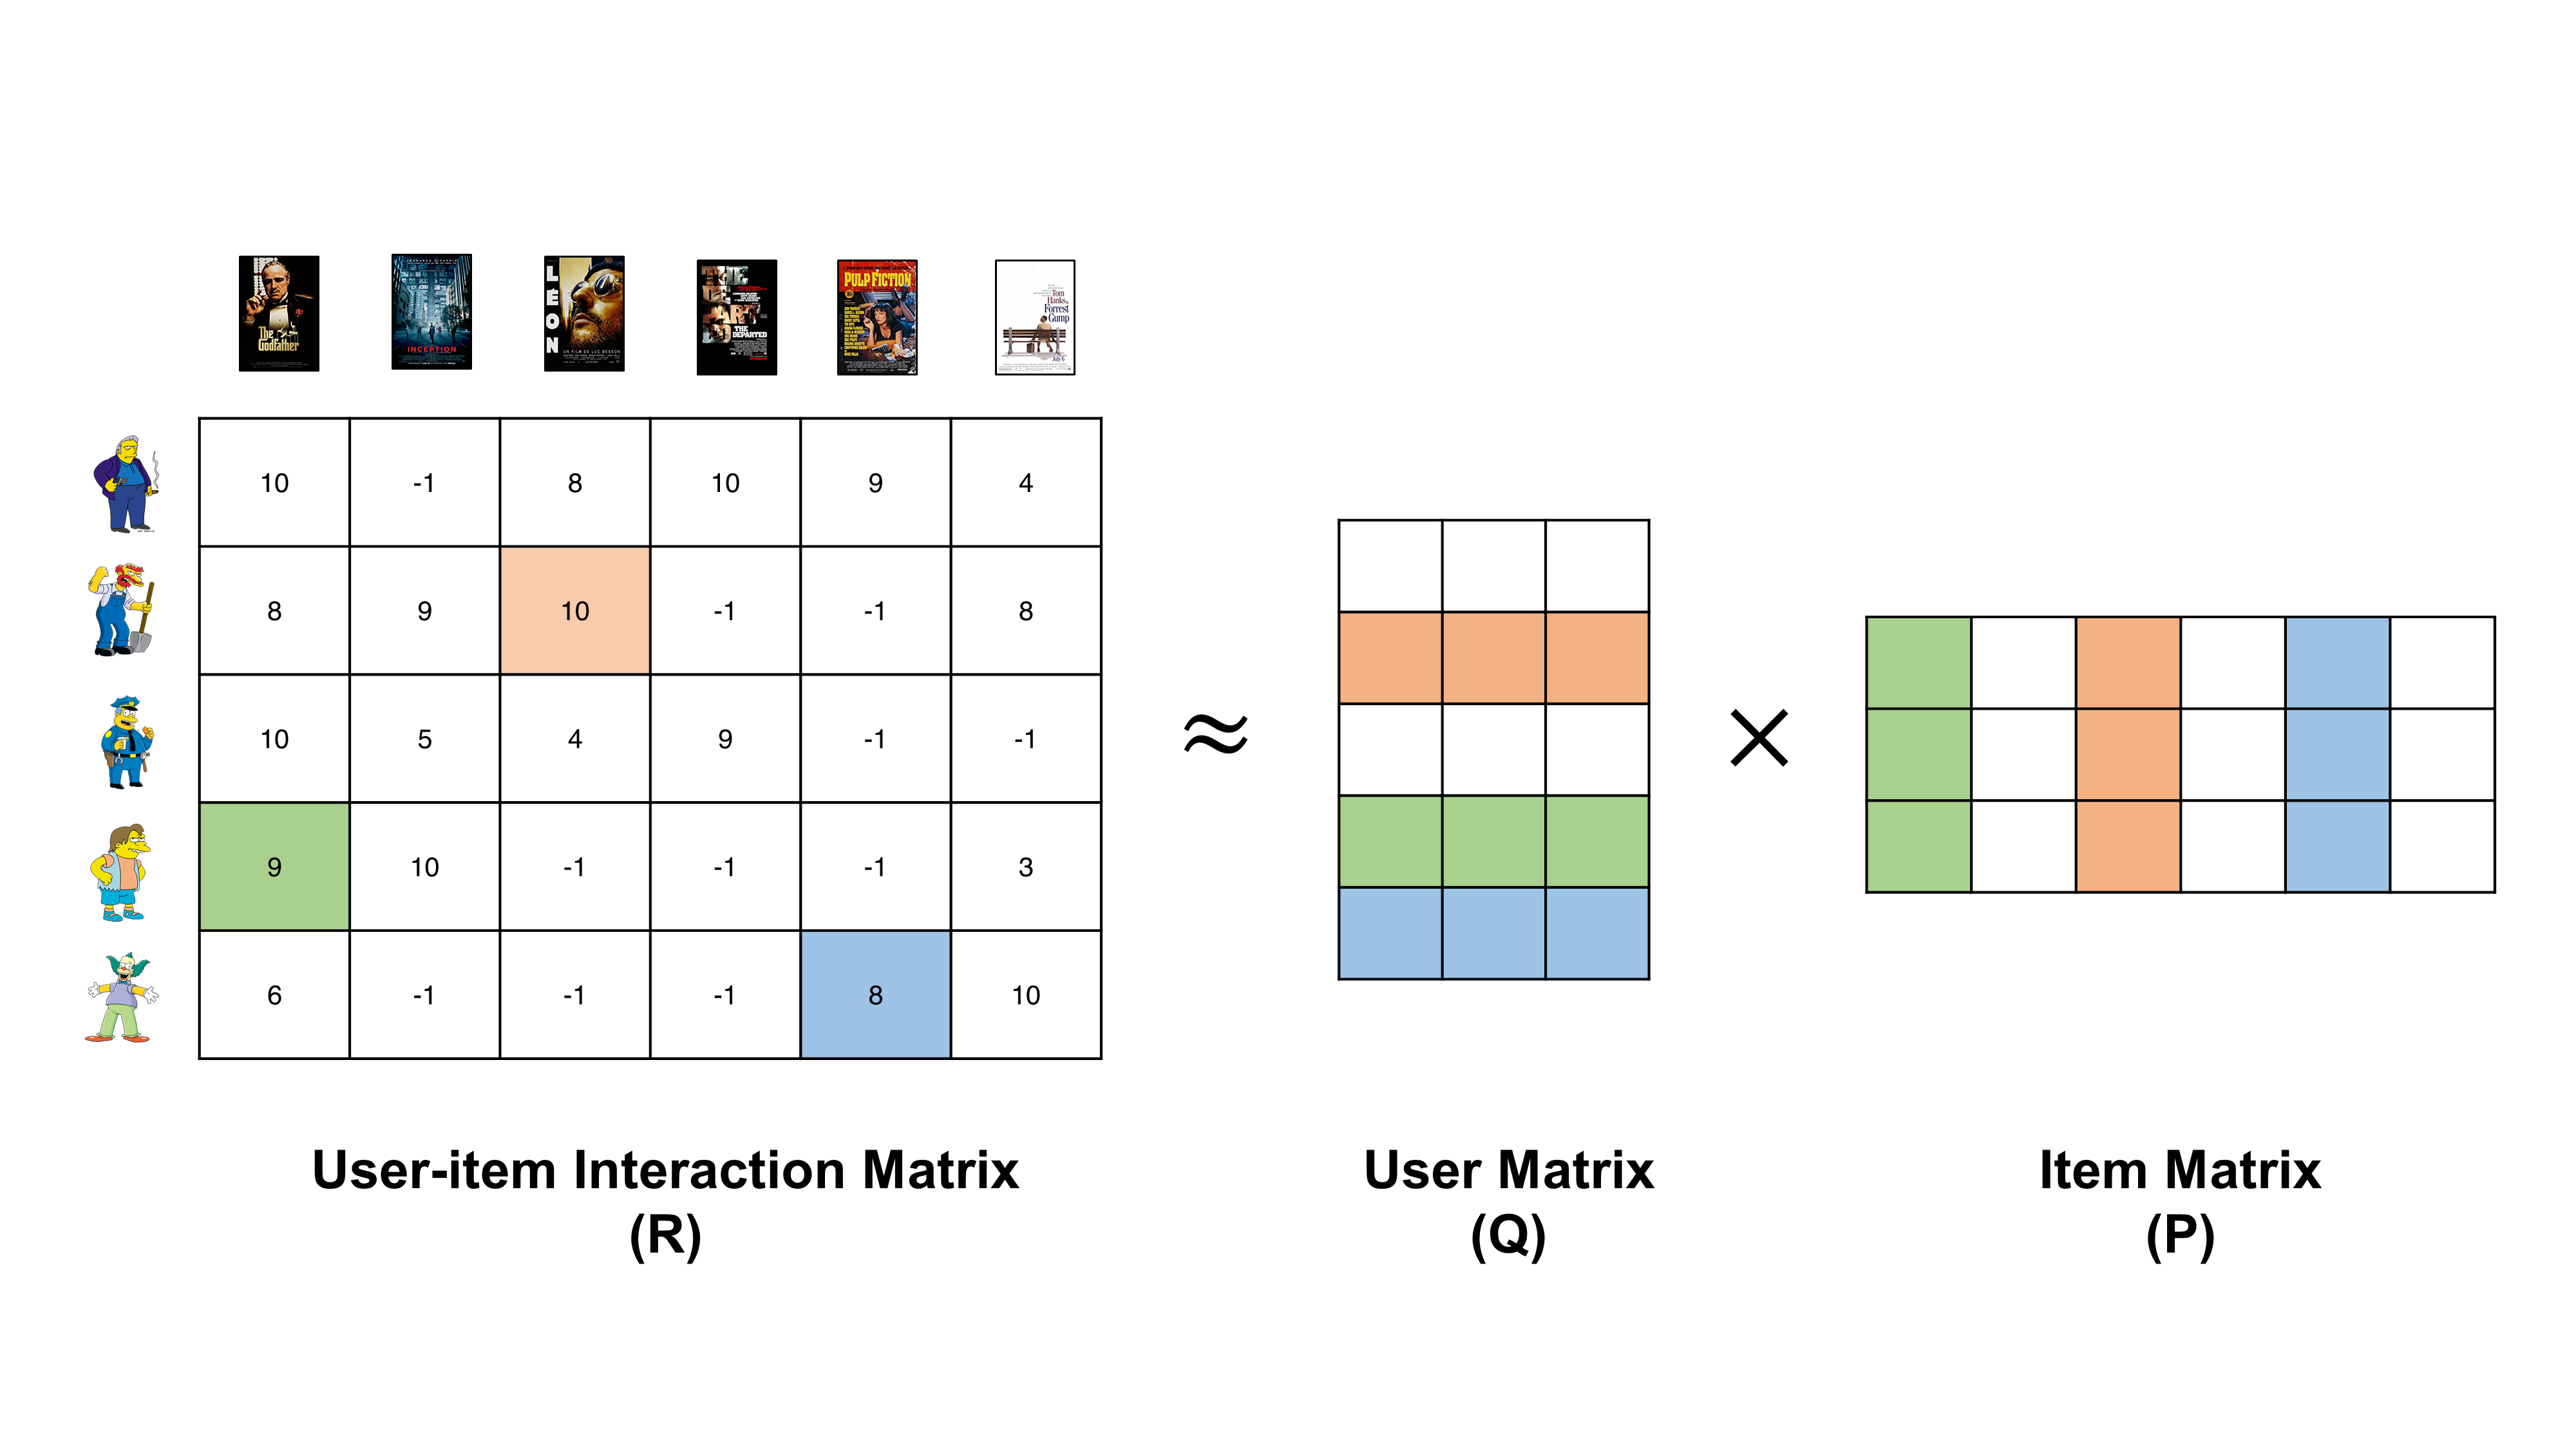

In [14]:
display(HTML(images_html[8]))


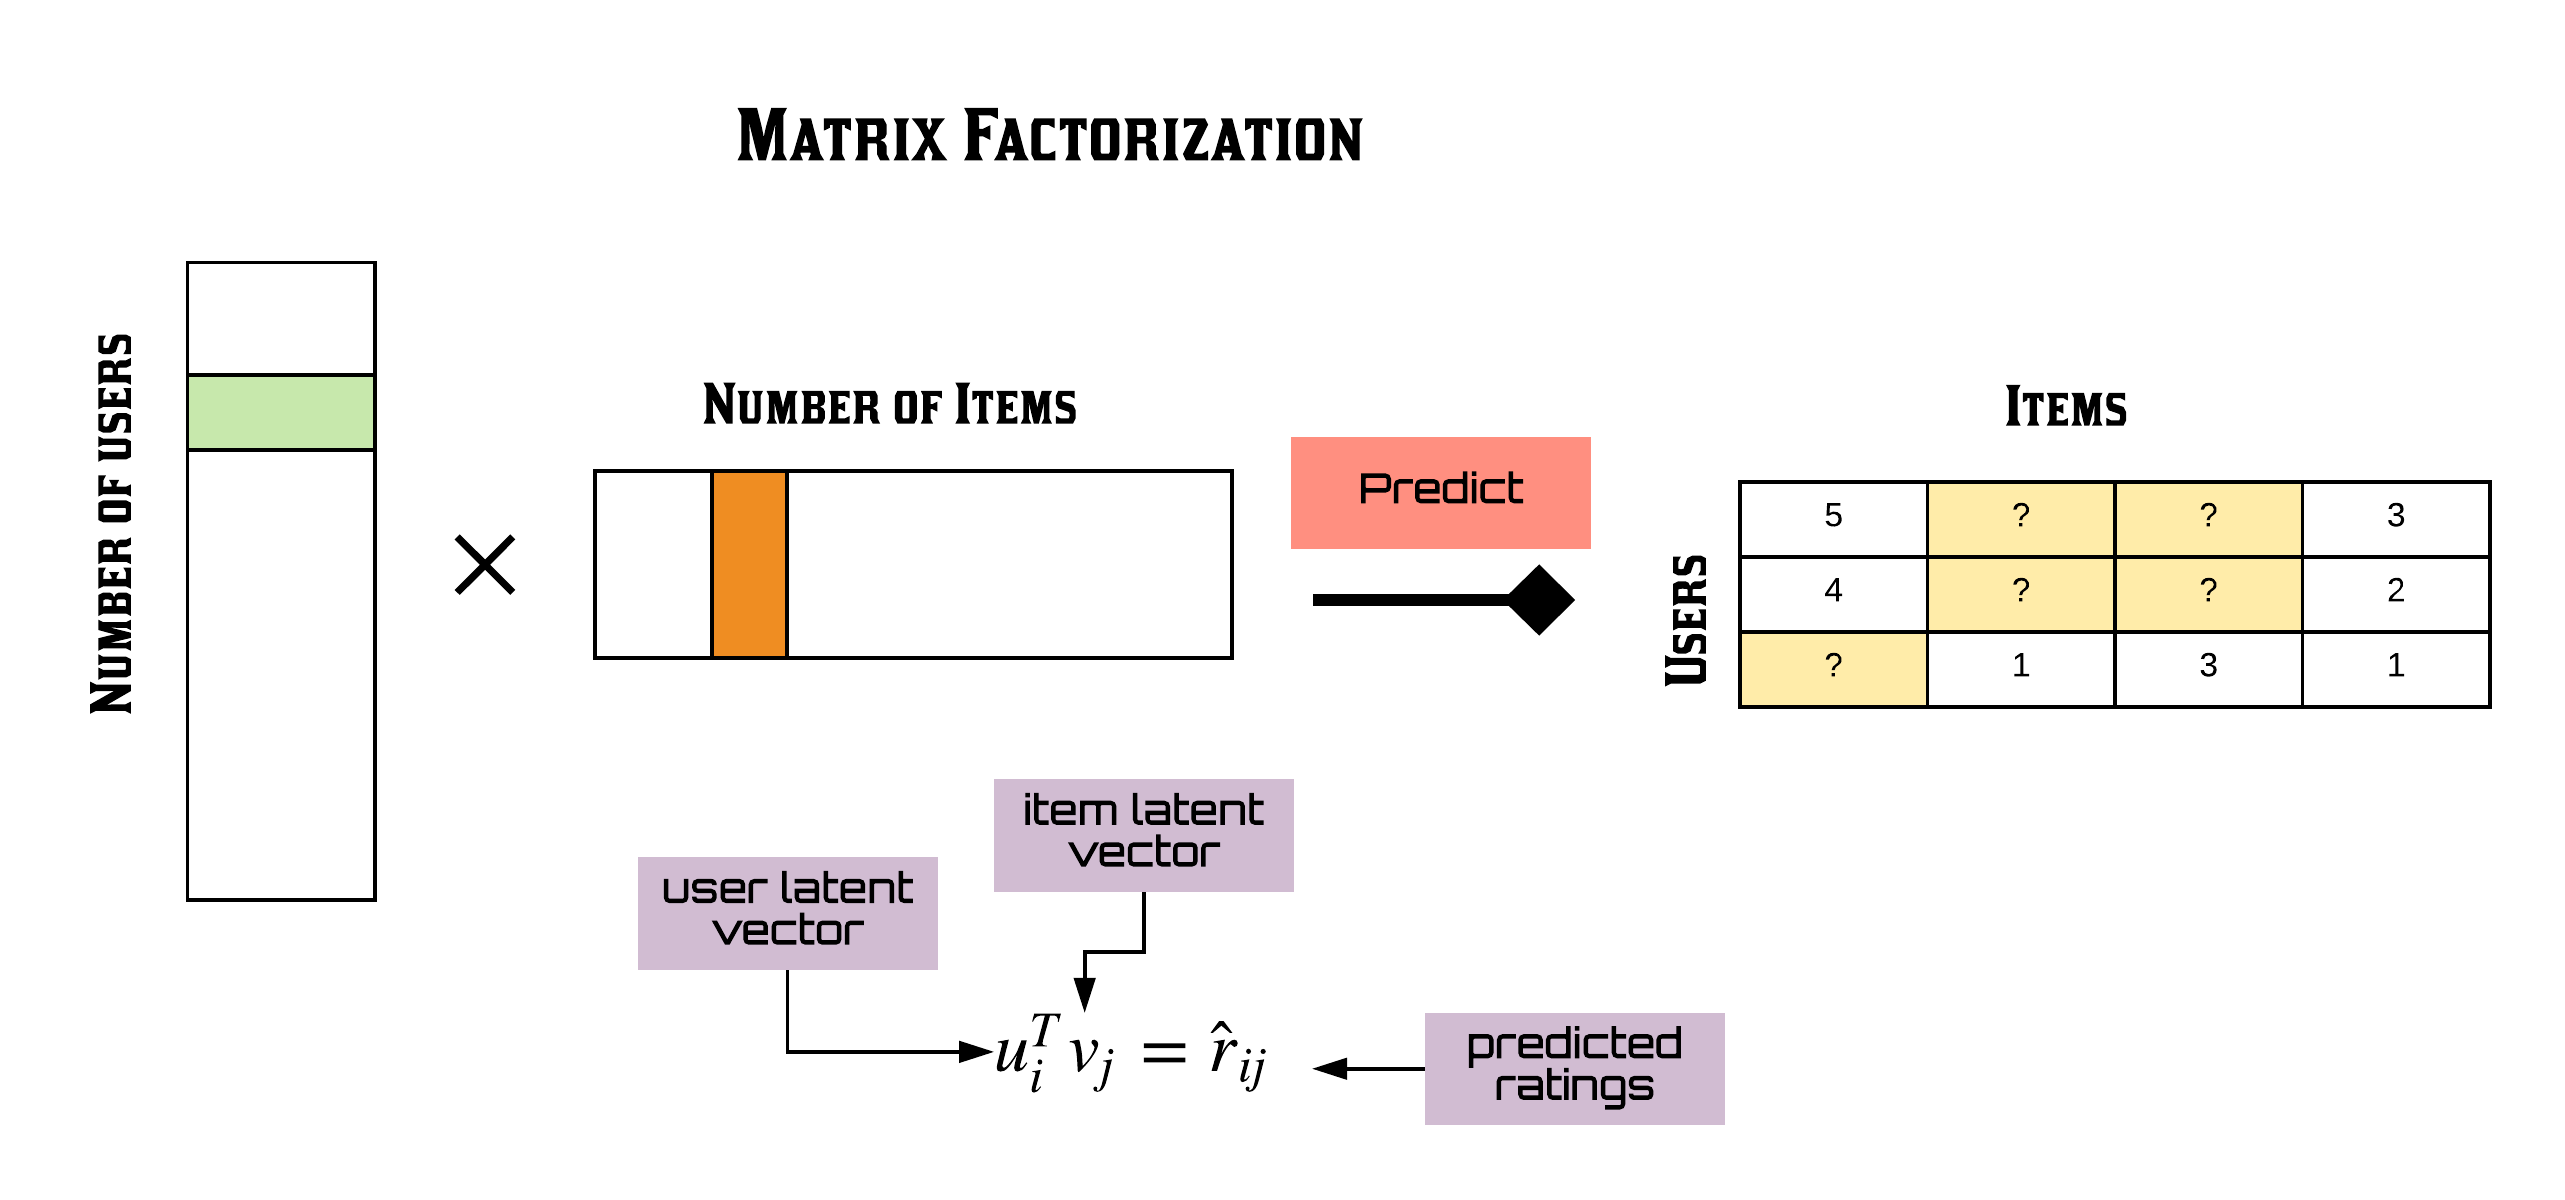

In [15]:
display(HTML(images_html[9]))

## Loading and preprocessing dataset

In [2]:
df_books = pd.read_csv('/kaggle/input/book-recommendation-dataset/Books.csv')
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [3]:
df_ratings = pd.read_csv('../input/book-recommendation-dataset/Ratings.csv')
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [4]:
df_books.dropna(inplace=True)
df_books.reset_index(drop=True,inplace=True)
df_books.drop(columns=["Book-Author","Publisher","Year-Of-Publication","Image-URL-S","Image-URL-M","Image-URL-L"],axis=1,inplace=True)
df_books["Book-Title"]=df_books["Book-Title"].apply(lambda x: re.sub("[\W_]+"," ",x).strip())
data = df_books.merge(df_ratings,on="ISBN")
data = data.rename(columns={"ISBN":"item_id","User-ID":"user_id","Book-Rating":"rating","Book-title":"book-title"})
print(data.shape)
data.head()

(1031128, 4)


,item_id,Book-Title,user_id,rating
0,0195153448,Classical Mythology,2,0
1,0002005018,Clara Callan,8,5
2,0002005018,Clara Callan,11400,0
3,0002005018,Clara Callan,11676,8
4,0002005018,Clara Callan,41385,0


In [5]:
usr_rm = df_ratings["User-ID"].value_counts()
usr_rm

User-ID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
          ...  
116180        1
116166        1
116154        1
116137        1
276723        1
Name: count, Length: 105283, dtype: int64

In [6]:
data = data[
  ~data["user_id"].isin(usr_rm[usr_rm < 50].index)
]

print(data.shape)
data.head()

(703427, 4)


,item_id,Book-Title,user_id,rating
2,0002005018,Clara Callan,11400,0
3,0002005018,Clara Callan,11676,8
6,0002005018,Clara Callan,85526,0
7,0002005018,Clara Callan,96054,0
8,0002005018,Clara Callan,116866,9


In [7]:
print(data["user_id"].value_counts())

user_id
11676     11144
198711     6456
153662     5814
98391      5777
35859      5646
          ...  
219389        4
100345        3
152464        3
76440         2
224108        1
Name: count, Length: 3426, dtype: int64


In [8]:
book_rm = df_ratings['ISBN'].value_counts() 
book_rm.sort_values(ascending=False).head()

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
Name: count, dtype: int64

In [9]:
data = data[
  ~data["item_id"].isin(book_rm[book_rm < 50].index)
]

data.reset_index(drop=True,inplace=True)

print(data.shape)
data.head()

(142073, 4)


,item_id,Book-Title,user_id,rating
0,0440234743,The Testament,277478,0
1,0440234743,The Testament,278144,0
2,0440234743,The Testament,243,0
3,0440234743,The Testament,2977,0
4,0440234743,The Testament,3363,0


In [10]:
print(f"Total interactions: {len(data)}")
print(f"Number of users: {data['user_id'].nunique()}")
print(f"Number of items: {data['item_id'].nunique()}")
print(f"Rating scale: {data['rating'].min()} to {data['rating'].max()}")

# Display first few rows
print("\nFirst 10 interactions:")
print(data.head(10))

print("\nLast 10 interactions:")
print(data.tail(10))

# Calculate and display sparsity
total_possible = data['user_id'].nunique() * data['item_id'].nunique()
actual_ratings = len(data)
sparsity_percentage = (1 - actual_ratings / total_possible) * 100
print(f"\nDataset sparsity: {sparsity_percentage:.1f}%")
print("(Sparsity measures how many user-item combinations have no rating)")

Total interactions: 142073
Number of users: 3271
Number of items: 2161
Rating scale: 0 to 10

First 10 interactions:
      item_id     Book-Title  user_id  rating
0  0440234743  The Testament   277478       0
1  0440234743  The Testament   278144       0
2  0440234743  The Testament      243       0
3  0440234743  The Testament     2977       0
4  0440234743  The Testament     3363       0
5  0440234743  The Testament     7346       9
6  0440234743  The Testament     9747       0
7  0440234743  The Testament     9856       0
8  0440234743  The Testament    11224       6
9  0440234743  The Testament    11676       9

Last 10 interactions:
           item_id                                         Book-Title  \
142063  0310205719  The Purpose Driven Life What on Earth Am I Her...   
142064  0310205719  The Purpose Driven Life What on Earth Am I Her...   
142065  0310205719  The Purpose Driven Life What on Earth Am I Her...   
142066  0310205719  The Purpose Driven Life What on Earth Am I

#### USER-ITEM MATRIX CREATION

This matrix forms the foundation of collaborative filtering algorithms. Rows represent users, columns represent items, and values represent ratings. Missing interactions are filled with zeros.  

In [11]:
def create_user_item_matrix(data):
    
    user_item_matrix = data.pivot_table(
        index='user_id', 
        columns='item_id', 
        values='rating',
        fill_value=0  # Fill missing values with 0 (no interaction)
    )
    
    # Create mappers for easy conversion between IDs and matrix indices
    user_mapper = {user: idx for idx, user in enumerate(user_item_matrix.index)}
    item_mapper = {item: idx for idx, item in enumerate(user_item_matrix.columns)}
    
    return user_item_matrix, user_mapper, item_mapper

# Create the user-item matrix
user_item_matrix, user_mapper, item_mapper = create_user_item_matrix(data)

print("\nUser-Item Matrix Created!")
print(f"Matrix shape: {user_item_matrix.shape}")
print(f"Matrix dimensions: {len(user_mapper)} users × {len(item_mapper)} items")



User-Item Matrix Created!
Matrix shape: (3271, 2161)
Matrix dimensions: 3271 users × 2161 items


#### USER-BASED COLLABORATIVE FILTERING

This algorithm finds users with similar preferences and recommends items that similar users have liked but the target user hasn't interacted with.
    
Key concepts:
- User similarity calculation using cosine similarity or Pearson correlation
  <br>] Cosine similarity measures the angle between user preference vectors,
  focusing on rating patterns rather than absolute rating levels.
  <br>Pearson correlation measures linear relationships between user ratings.
- Neighborhood formation based on similarity thresholds
  <br>] Neighborhood selection is crucial for recommendation quality.
  Larger neighborhoods provide more data but may include less relevant users.
  Similarity thresholds help filter out users with weak relationships.
- Rating prediction using weighted averages of similar users' ratings
  <br>] The prediction uses a weighted average of ratings from similar users,
  where weights are the similarity scores. This ensures that more
  similar users have greater influence on the prediction.


In [12]:
class UserBasedCollaborativeFiltering:
    
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.user_similarity_matrix = None
        
    def calculate_user_similarity(self, similarity_metric='cosine'):
        print(f"Calculating user similarity using {similarity_metric} similarity...")
        
        if similarity_metric == 'cosine':
            user_matrix = self.user_item_matrix.values
            similarity_matrix = cosine_similarity(user_matrix)
            
        elif similarity_metric == 'pearson':
            similarity_matrix = np.zeros((len(self.user_item_matrix), len(self.user_item_matrix)))
            
            for i in range(len(self.user_item_matrix)):
                for j in range(len(self.user_item_matrix)):
                    if i == j:
                        similarity_matrix[i, j] = 1.0
                    else:
                        # Get ratings for both users
                        user1_ratings = self.user_item_matrix.iloc[i].values
                        user2_ratings = self.user_item_matrix.iloc[j].values
                        
                        # Find items both users have rated (non-zero ratings)
                        mask = (user1_ratings > 0) & (user2_ratings > 0)
                        
                        if mask.sum() > 1:  # Need at least 2 common items
                            correlation, _ = pearsonr(user1_ratings[mask], user2_ratings[mask])
                            similarity_matrix[i, j] = correlation if not np.isnan(correlation) else 0
                        else:
                            similarity_matrix[i, j] = 0
        
        # Convert to DataFrame for easier handling
        self.user_similarity_matrix = pd.DataFrame(
            similarity_matrix,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )
        
        return self.user_similarity_matrix
    
    def find_similar_users(self, user_id, n_similar=10, min_similarity=0.1):
        if self.user_similarity_matrix is None:
            raise ValueError("User similarity matrix not calculated.")
        
        # Get similarity scores for the target user
        user_similarities = self.user_similarity_matrix.loc[user_id]
        
        # Remove the user itself and filter by minimum similarity
        user_similarities = user_similarities[user_similarities.index != user_id]
        user_similarities = user_similarities[user_similarities >= min_similarity]
        
        # Sort by similarity and return top N
        similar_users = user_similarities.sort_values(ascending=False).head(n_similar)
        
        return list(zip(similar_users.index, similar_users.values))
    
    def predict_rating(self, user_id, item_id, n_similar=10):
        similar_users = self.find_similar_users(user_id, n_similar)
        
        if not similar_users:
            item_ratings = self.user_item_matrix[item_id]
            item_ratings = item_ratings[item_ratings > 0]
            return item_ratings.mean() if len(item_ratings) > 0 else 3.0
        
        weighted_sum = 0
        similarity_sum = 0
        
        for similar_user, similarity in similar_users:
            rating = self.user_item_matrix.loc[similar_user, item_id]
            
            if rating > 0:  # Similar user has rated this item
                weighted_sum += similarity * rating
                similarity_sum += abs(similarity)
        
        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
        else:
            item_ratings = self.user_item_matrix[item_id]
            item_ratings = item_ratings[item_ratings > 0]
            predicted_rating = item_ratings.mean() if len(item_ratings) > 0 else 3.0
        
        return max(1, min(5, predicted_rating))

ubcf = UserBasedCollaborativeFiltering(user_item_matrix)
user_sim_matrix = ubcf.calculate_user_similarity('cosine')

print("\nUser-Based Collaborative Filtering Initialized!")
print("Sample user similarities calculated.")


Calculating user similarity using cosine similarity...

User-Based Collaborative Filtering Initialized!
Sample user similarities calculated.


#### ITEM-BASED COLLABORATIVE FILTERING

This algorithm finds items with similar rating patterns and recommends items that are similar to items the user has already liked.
    
Key advantages:
- More stable than user-based CF (item relationships change less frequently)
- Better handles user cold-start problem
- Can pre-compute item similarities for better performance
- Often provides more consistent recommendations

In [13]:
class ItemBasedCollaborativeFiltering:
    
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
        self.item_user_matrix = user_item_matrix.T
        self.item_similarity_matrix = None
        
    def calculate_item_similarity(self, similarity_metric='cosine'):
        print(f"Calculating item similarity using {similarity_metric} similarity...")
        
        if similarity_metric == 'cosine':
            # Use item-user matrix (items as rows)
            item_matrix = self.item_user_matrix.values
            
            # Calculate cosine similarity between items
            # This measures similarity based on user rating patterns
            similarity_matrix = cosine_similarity(item_matrix)
            
        elif similarity_metric == 'pearson':
            # Calculate Pearson correlation between items
            similarity_matrix = np.zeros((len(self.item_user_matrix), len(self.item_user_matrix)))
            
            for i in range(len(self.item_user_matrix)):
                for j in range(len(self.item_user_matrix)):
                    if i == j:
                        similarity_matrix[i, j] = 1.0
                    else:
                        # Get ratings for both items
                        item1_ratings = self.item_user_matrix.iloc[i].values
                        item2_ratings = self.item_user_matrix.iloc[j].values
                        
                        # Find users who rated both items
                        mask = (item1_ratings > 0) & (item2_ratings > 0)
                        
                        if mask.sum() > 1:  # Need at least 2 common users
                            correlation, _ = pearsonr(item1_ratings[mask], item2_ratings[mask])
                            similarity_matrix[i, j] = correlation if not np.isnan(correlation) else 0
                        else:
                            similarity_matrix[i, j] = 0
        
        # Convert to DataFrame for easier handling
        self.item_similarity_matrix = pd.DataFrame(
            similarity_matrix,
            index=self.item_user_matrix.index,
            columns=self.item_user_matrix.index
        )
        
        return self.item_similarity_matrix
    
    def find_similar_items(self, item_id, n_similar=10, min_similarity=0.1):
        if self.item_similarity_matrix is None:
            raise ValueError("Item similarity matrix not calculated.")
        
        # Get similarity scores for the target item
        item_similarities = self.item_similarity_matrix.loc[item_id]
        
        # Remove the item itself and filter by minimum similarity
        item_similarities = item_similarities[item_similarities.index != item_id]
        item_similarities = item_similarities[item_similarities >= min_similarity]
        
        # Sort by similarity and return top N
        similar_items = item_similarities.sort_values(ascending=False).head(n_similar)
        
        return list(zip(similar_items.index, similar_items.values))
    
    def predict_rating(self, user_id, item_id, n_similar=10):
        # Find similar items
        similar_items = self.find_similar_items(item_id, n_similar)
        
        if not similar_items:
            # No similar items found, return user's average rating
            user_ratings = self.user_item_matrix.loc[user_id]
            user_ratings = user_ratings[user_ratings > 0]
            return user_ratings.mean() if len(user_ratings) > 0 else 3.0
        
        # Calculate weighted average of user's ratings for similar items
        weighted_sum = 0
        similarity_sum = 0
        
        for similar_item, similarity in similar_items:
            # Get the user's rating for this similar item
            rating = self.user_item_matrix.loc[user_id, similar_item]
            
            if rating > 0:  # User has rated this similar item
                weighted_sum += similarity * rating
                similarity_sum += abs(similarity)
        
        if similarity_sum > 0:
            predicted_rating = weighted_sum / similarity_sum
        else:
            # User hasn't rated any similar items, use user average
            user_ratings = self.user_item_matrix.loc[user_id]
            user_ratings = user_ratings[user_ratings > 0]
            predicted_rating = user_ratings.mean() if len(user_ratings) > 0 else 3.0
        
        # Ensure predicted rating is within valid range
        return max(1, min(5, predicted_rating))

# Initialize item-based collaborative filtering
ibcf = ItemBasedCollaborativeFiltering(user_item_matrix)
item_sim_matrix = ibcf.calculate_item_similarity('cosine')

print("\nItem-Based Collaborative Filtering Initialized!")
print("Item similarities calculated based on user rating patterns.")


Calculating item similarity using cosine similarity...

Item-Based Collaborative Filtering Initialized!
Item similarities calculated based on user rating patterns.


#### TOP-N RECOMMENDATION GENERATION

Comprehensive recommendation engine that combines both user-based and item-based collaborative filtering to generate top-N recommendations.

The function implements sophisticated ranking mechanisms and filtering strategies
to ensure high-quality, personalized recommendations for users.

The ranking mechanism:
1. Identify items the user hasn't rated
2. Predict ratings for all unrated items using similar users
3. Rank items by predicted rating
4. Return top-N highest-rated items

In [14]:
bmap = data[["item_id","Book-Title"]]
bmap = bmap.drop_duplicates()
book_titles = {}
for i in range(len(bmap)):
    book_titles[bmap.iloc[i,0]]=bmap.iloc[i,1]
print(len(book_titles))

2161


In [15]:
class RecommendationEngine:
    def __init__(self, user_item_matrix, book_titles):
        self.user_item_matrix = user_item_matrix
        self.book_titles = book_titles
        self.ubcf = UserBasedCollaborativeFiltering(user_item_matrix)
        self.ibcf = ItemBasedCollaborativeFiltering(user_item_matrix)
        
        print("Initializing recommendation engine...")
        self.ubcf.calculate_user_similarity('cosine')
        self.ibcf.calculate_item_similarity('cosine')
    
    def get_unrated_items(self, user_id):
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_items = user_ratings[user_ratings == 0].index.tolist()
        return unrated_items
    
    def generate_user_based_recommendations(self, user_id, n_recommendations=10):
        # Get items the user hasn't rated
        unrated_items = self.get_unrated_items(user_id)
        
        # Predict ratings for all unrated items
        predictions = []
        for item_id in unrated_items:
            predicted_rating = self.ubcf.predict_rating(user_id, item_id)
            book_title = self.book_titles[item_id]
            predictions.append((item_id, predicted_rating, book_title))
        
        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]
    
    def generate_item_based_recommendations(self, user_id, n_recommendations=10):
        unrated_items = self.get_unrated_items(user_id)
        
        predictions = []
        for item_id in unrated_items:
            predicted_rating = self.ibcf.predict_rating(user_id, item_id)
            book_title = self.book_titles[item_id]
            predictions.append((item_id, predicted_rating, book_title))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]
    
    def generate_hybrid_recommendations(self, user_id, n_recommendations=10, alpha=0.5):
        unrated_items = self.get_unrated_items(user_id)
        
        predictions = []
        for item_id in unrated_items:
            user_based_rating = self.ubcf.predict_rating(user_id, item_id)
            item_based_rating = self.ibcf.predict_rating(user_id, item_id)
            
            # Combine ratings using weighted average
            combined_rating = alpha * user_based_rating + (1 - alpha) * item_based_rating
            book_title = self.book_titles[item_id]
            predictions.append((item_id, combined_rating, book_title))
        
        predictions.sort(key=lambda x: x[1], reverse=True)
        return predictions[:n_recommendations]

# Initialize and demonstrate recommendation engine
rec_engine = RecommendationEngine(user_item_matrix, book_titles)

# Demonstrate recommendations for a specific user
target_user = data["user_id"][0]

print(f"\n--- DEMONSTRATION: Recommendations for User {target_user} ---")

# Show user's rating history
user_ratings = user_item_matrix.loc[target_user]
rated_items = user_ratings[user_ratings > 0]
print(f"\nUser {target_user}'s Rating History:")
for item_id, rating in rated_items.items():
    book_title = book_titles[item_id]
    print(f"  {book_title}: {rating}")

# Generate different types of recommendations
print(f"\n--- USER-BASED RECOMMENDATIONS ---")
user_based_recs = rec_engine.generate_user_based_recommendations(target_user, 5)
for i, (item_id, rating, title) in enumerate(user_based_recs, 1):
    print(f"{i}. {title} (predicted rating: {rating:.2f})")

print(f"\n--- ITEM-BASED RECOMMENDATIONS ---")
item_based_recs = rec_engine.generate_item_based_recommendations(target_user, 5)
for i, (item_id, rating, title) in enumerate(item_based_recs, 1):
    print(f"{i}. {title} (predicted rating: {rating:.2f})")

print(f"\n--- HYBRID RECOMMENDATIONS ---")
hybrid_recs = rec_engine.generate_hybrid_recommendations(target_user, 5)
for i, (item_id, rating, title) in enumerate(hybrid_recs, 1):
    print(f"{i}. {title} (predicted rating: {rating:.2f})")


Initializing recommendation engine...
Calculating user similarity using cosine similarity...
Calculating item similarity using cosine similarity...

--- DEMONSTRATION: Recommendations for User 277478 ---

User 277478's Rating History:
  A Place of Execution: 7.0
  Chicken Soup for the Pet Lover s Soul Chicken Soup for the Soul: 8.0

--- USER-BASED RECOMMENDATIONS ---
1. Angelas Ashes (predicted rating: 5.00)
2. Billy (predicted rating: 5.00)
3. AGE OF INNOCENCE MOVIE TIE IN (predicted rating: 5.00)
4. Lion the Witch and the Wardrobe (predicted rating: 5.00)
5. Politically Correct Bedtime Stories Modern Tales for Our Life and Times (predicted rating: 5.00)

--- ITEM-BASED RECOMMENDATIONS ---
1. Angelas Ashes (predicted rating: 5.00)
2. Billy (predicted rating: 5.00)
3. AGE OF INNOCENCE MOVIE TIE IN (predicted rating: 5.00)
4. Lion the Witch and the Wardrobe (predicted rating: 5.00)
5. Politically Correct Bedtime Stories Modern Tales for Our Life and Times (predicted rating: 5.00)

--- H

#### RECOMMENDATION EVALUATION

Comprehensive evaluation framework for recommendation systems.
Implements various metrics to assess recommendation quality and system performance.
    
Key evaluation metrics:
- Precision@K: Proportion of relevant items in top-K recommendations
  <br>Precision@K = (# of relevant items in top-K) / K
  <br>High precision indicates that most recommended items are relevant, leading to better user satisfaction with the recommendations.
- Recall@K: Coverage of relevant items in top-K recommendations
  <br>Recall@K = (# of relevant items in top-K) / (total # of relevant items)
  <br>High recall indicates that the system captures most items of interest, reducing the chance of missing valuable recommendations.
- F1-Score@K: Harmonic mean of precision and recall
  <br>F1@K = 2 * (Precision@K * Recall@K) / (Precision@K + Recall@K)
  <br>F1-score provides a balanced measure that considers both precision and recall, useful when both metrics are important for system performance.
        

In [16]:
class RecommendationEvaluator:
    def __init__(self, user_item_matrix):
        self.user_item_matrix = user_item_matrix
    
    def create_train_test_split(self, test_ratio=0.2, random_state=42):
        # Convert matrix to list of interactions
        interactions = []
        for user_id in self.user_item_matrix.index:
            for item_id in self.user_item_matrix.columns:
                rating = self.user_item_matrix.loc[user_id, item_id]
                if rating > 0:
                    interactions.append((user_id, item_id, rating))
        
        # Split interactions
        train_interactions, test_interactions = train_test_split(
            interactions, test_size=test_ratio, random_state=random_state
        )
        
        # Create training matrix
        train_matrix = self.user_item_matrix.copy()
        train_matrix.iloc[:, :] = 0  # Reset all values
        
        # Fill training matrix
        for user_id, item_id, rating in train_interactions:
            train_matrix.loc[user_id, item_id] = rating
        
        return train_matrix, test_interactions
    
    def precision_at_k(self, recommended_items, relevant_items, k):
        if k == 0:
            return 0.0
        
        top_k_recommendations = set(recommended_items[:k])
        relevant_in_top_k = top_k_recommendations.intersection(relevant_items)
        
        return len(relevant_in_top_k) / k
    
    def recall_at_k(self, recommended_items, relevant_items, k):
        if len(relevant_items) == 0:
            return 0.0
        
        top_k_recommendations = set(recommended_items[:k])
        relevant_in_top_k = top_k_recommendations.intersection(relevant_items)
        
        return len(relevant_in_top_k) / len(relevant_items)
    
    def f1_score_at_k(self, recommended_items, relevant_items, k):
        precision = self.precision_at_k(recommended_items, relevant_items, k)
        recall = self.recall_at_k(recommended_items, relevant_items, k)
        
        if precision + recall == 0:
            return 0.0
        
        return 2 * (precision * recall) / (precision + recall)
    
    def evaluate_system(self, recommendation_engine, k_values=[5, 10], rating_threshold=4.0):
        # Create train-test split
        train_matrix, test_interactions = self.create_train_test_split()
        
        # Group test interactions by user
        user_test_items = {}
        for user_id, item_id, rating in test_interactions:
            if user_id not in user_test_items:
                user_test_items[user_id] = []
            user_test_items[user_id].append((item_id, rating))
        
        # Initialize results storage
        results = {
            'user_based': {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values},
            'item_based': {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values},
            'hybrid': {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values}
        }
        
        # Create recommendation engine with training data
        train_rec_engine = RecommendationEngine(train_matrix, book_titles)
        
        # Evaluate for each user
        for user_id, test_items in user_test_items.items():
            # Get relevant items (high-rated items in test set)
            relevant_items = set([
                item_id for item_id, rating in test_items 
                if rating >= rating_threshold
            ])
            
            if len(relevant_items) == 0:
                continue  # Skip users with no relevant items
            
            # Generate recommendations
            max_k = max(k_values)
            user_based_recs = train_rec_engine.generate_user_based_recommendations(user_id, max_k)
            item_based_recs = train_rec_engine.generate_item_based_recommendations(user_id, max_k)
            hybrid_recs = train_rec_engine.generate_hybrid_recommendations(user_id, max_k)
            
            # Extract item IDs
            user_based_items = [item_id for item_id, _, _ in user_based_recs]
            item_based_items = [item_id for item_id, _, _ in item_based_recs]
            hybrid_items = [item_id for item_id, _, _ in hybrid_recs]
            
            # Calculate metrics for different K values
            for k in k_values:
                for method, items in [('user_based', user_based_items), 
                                    ('item_based', item_based_items), 
                                    ('hybrid', hybrid_items)]:
                    results[method][k]['precision'].append(
                        self.precision_at_k(items, relevant_items, k)
                    )
                    results[method][k]['recall'].append(
                        self.recall_at_k(items, relevant_items, k)
                    )
                    results[method][k]['f1'].append(
                        self.f1_score_at_k(items, relevant_items, k)
                    )
        
        # Calculate average metrics
        avg_results = {}
        for method in ['user_based', 'item_based', 'hybrid']:
            avg_results[method] = {}
            for k in k_values:
                avg_results[method][k] = {
                    'precision': np.mean(results[method][k]['precision']),
                    'recall': np.mean(results[method][k]['recall']),
                    'f1': np.mean(results[method][k]['f1'])
                }
        
        return avg_results

evaluator = RecommendationEvaluator(user_item_matrix)
evaluation_results = evaluator.evaluate_system(rec_engine, k_values=[5, 10])

print("\nEVALUATION RESULTS:")
print("-" * 40)

for method in ['user_based', 'item_based', 'hybrid']:
    print(f"\n{method.upper().replace('_', '-')} COLLABORATIVE FILTERING:")
    for k in [5, 10]:
        precision = evaluation_results[method][k]['precision']
        recall = evaluation_results[method][k]['recall']
        f1 = evaluation_results[method][k]['f1']
        print(f"  @{k}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

print("\nMetric Interpretation:")
print("- Precision@K: Fraction of recommended items that are relevant")
print("- Recall@K: Fraction of relevant items that are recommended")
print("- F1@K: Harmonic mean balancing precision and recall")
print("- Higher values indicate better performance")

Initializing recommendation engine...
Calculating user similarity using cosine similarity...
Calculating item similarity using cosine similarity...

EVALUATION RESULTS:
----------------------------------------

USER-BASED COLLABORATIVE FILTERING:
  @5: Precision=0.001, Recall=0.002, F1=0.001
  @10: Precision=0.001, Recall=0.003, F1=0.001

ITEM-BASED COLLABORATIVE FILTERING:
  @5: Precision=0.001, Recall=0.002, F1=0.001
  @10: Precision=0.001, Recall=0.003, F1=0.001

HYBRID COLLABORATIVE FILTERING:
  @5: Precision=0.001, Recall=0.002, F1=0.001
  @10: Precision=0.001, Recall=0.003, F1=0.001

Metric Interpretation:
- Precision@K: Fraction of recommended items that are relevant
- Recall@K: Fraction of relevant items that are recommended
- F1@K: Harmonic mean balancing precision and recall
- Higher values indicate better performance


**Key Differences:**
- Cosine similarity focuses on rating patterns (direction)
- Pearson correlation considers rating scale differences
- Cosine is more robust to rating scale variations
- Pearson captures linear relationships better

**Sparsity Impact:**
- Reduces overlap between users/items
- Makes similarity calculations less reliable
- Can lead to poor recommendation quality
- Requires advanced techniques for mitigation

**Mitigation Strategies:**
- Matrix factorization techniques
- Dimensionality reduction
- Hybrid recommendation approaches
- Implicit feedback incorporation

1. NEW USER COLD START:
   Problem: No rating history for new users
   Solutions:
   - Onboarding preference collection
   - Demographic-based recommendations
   - Popular item recommendations
   - Hybrid content-based approaches

2. NEW ITEM COLD START:
   Problem: No ratings for new items
   Solutions:
   - Content-based similarity
   - Expert ratings and reviews
   - Promotional strategies
   - Feature-based recommendations

3. SYSTEM COLD START:
   Problem: No historical data available
   Solutions:
   - External data bootstrapping
   - Non-personalized recommendations
   - User participation incentives
   - Transfer learning approaches

**USER-BASED VS ITEM-BASED COLLABORATIVE FILTERING:**
1. User-Based:
  + Better for discovering diverse items
  + Good serendipity and exploration
  - Sensitive to user preferences changes
  - Computationally expensive with many users

2. Item-Based:
  + More stable recommendations
  + Better scalability
  + Handles user cold-start better
  - May be less diverse

**IMPLEMENTATION BEST PRACTICES:**
  - Proper data preprocessing and normalization
  - Appropriate similarity metric selection
  - Careful neighborhood size tuning
  - Regular evaluation and monitoring
  - Consideration of scalability requirements

**EVALUATION CONSIDERATIONS:**
  - Multiple metrics provide different insights
  - Offline evaluation may not reflect online performance
  - Consider diversity and novelty alongside accuracy
  - A/B testing for real-world validation

**Key concepts**
- Collaborative filtering fundamentals
- User-based and item-based implementations
- Top-N recommendation generation
- Evaluation metrics and methodologies
- Core challenges and mitigation strategies
- Best practices for real-world deployment